# Versão 3 dos testes realizados para o modelo



In [28]:
import pandas as pd
import os, re, io
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression


In [29]:
# Lê as propostas com o Pandas
propostas = pd.read_csv("../../production/data_extraction/propostas.csv")

propostas  # Impressão do DataFrame de propostas

,Categoria,Texto
0,Turismo,Turismo: esse é o Destino. <p><strong>Objetivo...
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. <p><stron...
2,Agricultura e Pecuária,Agropecuária Sustentável. <p>Objetivo: Contrib...
3,Saúde,Atenção Primária à Saúde. <p>Fortalecer a Aten...
4,Saúde,Atenção Especializada à Saúde. <p>Ampliar o ac...
...,...,...
8431,Saúde,Microchipagem de animais de companhia. Microch...
8432,Secretaria Geral da Presidência da República,"Direito a atendimento eficiente, é um direito..."
8433,Previdência Social,Rever Reforma da Previdência. Rever a reforma ...
8434,Meio Ambiente e Mudança do Clima,Preservação da Serra do Espinhaço. A Serra do ...


In [30]:
# Expressões regulares para remoção de poluição de dados nos textos 
# REGX_URL = r"https?://[A-Za-z0-9./\-]+" # Regex for URLs
REGX_HTML = r"<[^<]+?>" # Regex for HTML tags
REGX_ENDING = r'Órgão Responsável:.+' # Regex for the part of the text

In [31]:
# Função para pré-processamento
def preprocessing(text):
  # text = text.lower()

  text = re.sub(REGX_HTML, '', text)  # Removendo tags HTML
  # text = re.sub(REGX_URL, '', text) # Revomendo URLs
  text = re.sub(REGX_ENDING, '', text)

  # tokens = [t.lemma_ for t in nlp(text) if t not in STOP_WORDS and not t.is_punct]

  return text

#  Ajustando textos da coluna Corpo
propostas['Texto'] = propostas['Texto'].apply(preprocessing)
propostas.head()

,Categoria,Texto
0,Turismo,Turismo: esse é o Destino. Objetivo: Posiciona...
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. Objetivo:...
2,Agricultura e Pecuária,Agropecuária Sustentável. Objetivo: Contribuir...
3,Saúde,Atenção Primária à Saúde. Fortalecer a Atenção...
4,Saúde,Atenção Especializada à Saúde. Ampliar o acess...


## Adcionando dados abertos do Ministerio de  Relações Exteriores  para a categora de  Relações Exteriores 

# Dados extraidos do concordia MRE-Gov (https://dados.gov.br/dados/organizacoes/visualizar/ministerio-das-relacoes-exteriores-mre) 

In [32]:
import chardet

# Detecta a codificação do arquivo CSV
with open("../../production/data_extraction/MRE.csv", 'rb') as f:
    result = chardet.detect(f.read())
encoding = result['encoding']

# Lê o CSV usando a codificação detectada
relacoes_ext = pd.read_csv('../../production/data_extraction/MRE.csv', sep=';', encoding='latin-1')

# retira colunas 
colunas_retiradas = ['Unnamed: 1', 'Unnamed: 2','Unnamed: 3','Unnamed: 4','Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10']
relacoes_ext = relacoes_ext.drop(index=0,columns=colunas_retiradas)

# Renomeia colunas e retira primeira linha

relacoes_ext.columns = ['Categoria', 'Texto']

# Combina os textos das colunas 1 e 2 na coluna 2
relacoes_ext['Texto'] = relacoes_ext['Categoria'] + ' ' + relacoes_ext['Texto']

# Renomeie todas as linhas da coluna 'Categoria' para 'Relações Exteriores'
relacoes_ext['Categoria'] = 'Relações Exteriores'

In [33]:
#removendo as tags html da cooluna texto
from bs4 import BeautifulSoup

# Função para limpar os dados de tags HTML e quebras de linha
def clean_text(text):
    if isinstance(text, str):  # Verifica se é uma string
        # Remove as tags HTML com BeautifulSoup
        cleaned = BeautifulSoup(text, 'html.parser').get_text()
        # Remove as quebras de linha com expressões regulares
        cleaned = re.sub(r'\n', ' ', cleaned)
        return cleaned.strip()
    return text  # Retorna o valor original se não for uma string

# Aplica a função de limpeza aos dados da coluna 'Texto'
relacoes_ext['Texto'] = relacoes_ext['Texto'].apply(clean_text)


/tmp/ipykernel_9868/2471177091.py:8: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  cleaned = BeautifulSoup(text, 'html.parser').get_text()


In [34]:
relacoes_ext.head()

,Categoria,Texto
1,Relações Exteriores,Acordo-Quadro entre o Governo da República Fed...
2,Relações Exteriores,Memorando de Entendimento sobre Diálogo Consul...
3,Relações Exteriores,Memorando de Entendimento sobre Cooperação Aca...
4,Relações Exteriores,MEMORANDO DE ENTENDIMENTO ENTRE O MINISTÉRIO D...
5,Relações Exteriores,Declaração Conjunta de Brasília entre o Presid...


In [35]:
# Use o método concat para adicionar os dados do DataFrame relacoes_ext ao DataFrame propostas
frames = [propostas,relacoes_ext]
propostas = pd.concat(frames, ignore_index=True)

# Realizando a primeira separacao em dados de treino e teste


In [36]:
from sklearn.model_selection import train_test_split

treino, teste, classe_treino, classe_teste = train_test_split(propostas.Texto,
                                                              propostas.Categoria,
                                                              random_state = 42)



In [37]:
treino

15885    Declaração Conjunta sobre os resultados das co...
1498     Pavimentação Asfáltica. Asfaltamento  da MA 33...
13896    Ajuste Complementar ao Acordo de Cooperação Té...
13829    Protocolo de Intenções entre o Governo da Repú...
19571                           Acordo Comercial. Comércio
                               ...                        
11284    Protocolo Adicional do Acordo de Alcance Parci...
11964    IV Reunião de Chanceleres dos Países da Bacia ...
5390     Banco de Projetos de Produção para Pequeno Pro...
860      Realizar a Conferência Nacional da Gestão e In...
15795    Memorando de Entendimento entre o Governo da R...
Name: Texto, Length: 15452, dtype: object

In [38]:
classe_treino


15885                               Relações Exteriores
1498                                        Transportes
13896                               Relações Exteriores
13829                               Relações Exteriores
19571                               Relações Exteriores
                              ...                      
11284                               Relações Exteriores
11964                               Relações Exteriores
5390     Desenvolvimento Agrário e Agricultura Familiar
860              Gestão e Inovação em Serviços Públicos
15795                               Relações Exteriores
Name: Categoria, Length: 15452, dtype: object

In [39]:
print(propostas.Categoria.value_counts())

Categoria
Relações Exteriores                                               12179
Saúde                                                              1368
Educação                                                           1261
Direitos Humanos e Cidadania                                        528
Meio Ambiente e Mudança do Clima                                    497
Transportes                                                         473
Desenvolvimento e Assistência Social, Família e Combate à Fome      418
Trabalho e Emprego                                                  377
Justiça e Segurança Pública                                         342
Cidades                                                             294
Gestão e Inovação em Serviços Públicos                              284
Desenvolvimento Agrário e Agricultura Familiar                      255
Previdência Social                                                  249
Cultura                                               

In [40]:
propostas['Texto'][0]

'Turismo: esse é o Destino. Objetivo: Posicionar o turismo como vetor de desenvolvimento sustentável e aumentar a competitividade dos destinos e produtos turísticos brasileiros, democratizando o acesso à atividade turística aos cidadãos brasileiros.'

In [41]:
#Criando índices para as categorias
cats = propostas['Categoria'].unique() # Pegando cada categoria única
cats = dict(enumerate(cats, 0)) # Convertendo para dict (com índices enumerados)
cats = {v:k for k,v in cats.items()}  # Trocando chaves e valores

propostas['id_cats'] = propostas['Categoria'].map(cats) # Inserindo coluna de índices das cats
propostas.head()

,Categoria,Texto,id_cats
0,Turismo,Turismo: esse é o Destino. Objetivo: Posiciona...,0
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. Objetivo:...,1
2,Agricultura e Pecuária,Agropecuária Sustentável. Objetivo: Contribuir...,2
3,Saúde,Atenção Primária à Saúde. Fortalecer a Atenção...,3
4,Saúde,Atenção Especializada à Saúde. Ampliar o acess...,3


In [42]:
# Remova valores não processáveis da coluna 'Texto'
propostas = propostas[propostas['Texto'].apply(lambda x: isinstance(x, str))]

# Inicialize o modelo de regressão logística
regressao_logistica = LogisticRegression(solver="lbfgs", max_iter=1000)

def classificar_texto(texto, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar.fit_transform(texto[coluna_texto])
    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                                  texto[coluna_classificacao],
                                                                  random_state=42)
    regressao_logistica.fit(treino, classe_treino)
    return regressao_logistica.score(teste, classe_teste)

acuracia_bruta = classificar_texto(propostas, "Texto", "id_cats")

print("Acurácia:", acuracia_bruta)



Acurácia: 0.6771500679479713


In [43]:
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt

todas_palavras = ' '.join([texto for texto in propostas.Texto])


In [44]:
import nltk
from nltk import tokenize

# realiza a tokenização do texto
token_espaco = tokenize.WhitespaceTokenizer()
token_frase = token_espaco.tokenize(todas_palavras)

frequencia = nltk.FreqDist(token_frase)
df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                   "Frequência": list(frequencia.values())})



In [45]:
# imprime um data frame com as palavras ordenadas pelas q tem a maior frequencia
df_frequencia.nlargest(columns = "Frequência", n = 10)

,Palavra,Frequência
10,de,51612
13,e,38678
66,do,23705
51,da,22879
3,o,21396
15,a,21169
49,para,14704
6113,República,11438
217,entre,9307
1044,Governo,8952


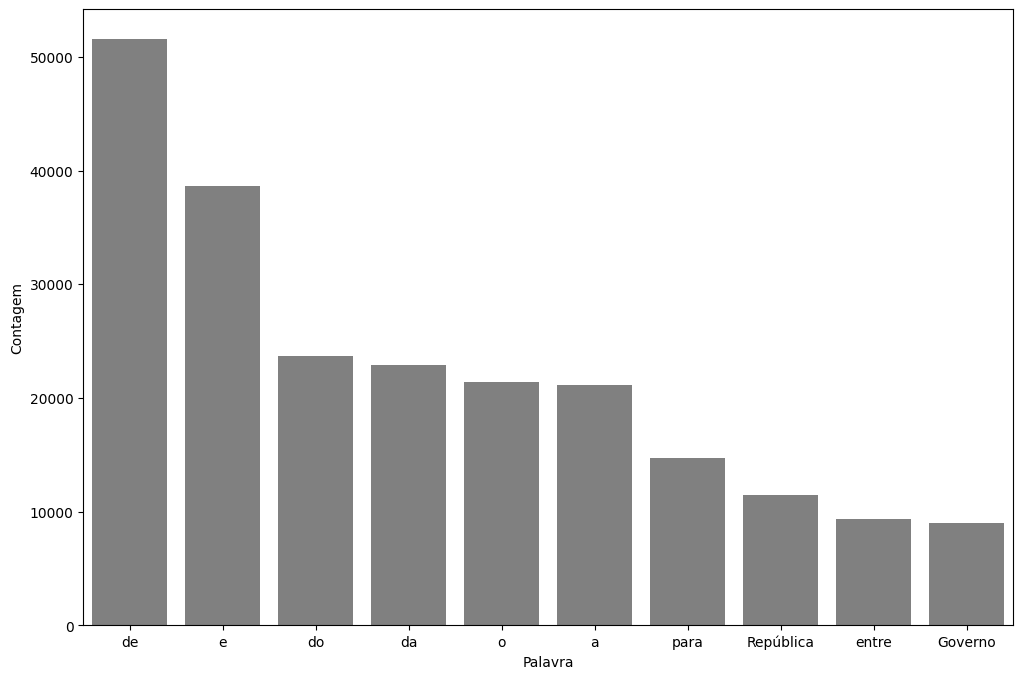

In [46]:
import seaborn as sns

def pareto(texto, coluna_texto, quantidade):
    todas_palavras = ' '.join([texto for texto in texto[coluna_texto]])
    token_frase = token_espaco.tokenize(todas_palavras)
    frequencia = nltk.FreqDist(token_frase)
    df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                                   "Frequência": list(frequencia.values())})
    df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = quantidade)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequencia, x = "Palavra", y = "Frequência", color = 'gray')
    ax.set(ylabel = "Contagem")
    plt.show()

pareto(propostas, "Texto", 10)

In [47]:
palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")

frase_processada = list()
for opiniao in propostas.Texto:
    nova_frase = list()
    palavras_texto = token_espaco.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in palavras_irrelevantes:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

propostas["tratamento_1"] = frase_processada


In [48]:
propostas.head()

,Categoria,Texto,id_cats,tratamento_1
0,Turismo,Turismo: esse é o Destino. Objetivo: Posiciona...,0,Turismo: Destino. Objetivo: Posicionar turismo...
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. Objetivo:...,1,Agricultura Familiar Agroecologia. Objetivo: F...
2,Agricultura e Pecuária,Agropecuária Sustentável. Objetivo: Contribuir...,2,Agropecuária Sustentável. Objetivo: Contribuir...
3,Saúde,Atenção Primária à Saúde. Fortalecer a Atenção...,3,Atenção Primária Saúde. Fortalecer Atenção Pri...
4,Saúde,Atenção Especializada à Saúde. Ampliar o acess...,3,Atenção Especializada Saúde. Ampliar acesso aç...


In [49]:
acuracia_tratamento_1 = classificar_texto(propostas, "tratamento_1", "id_cats")
print(acuracia_tratamento_1)

0.6856920986216268


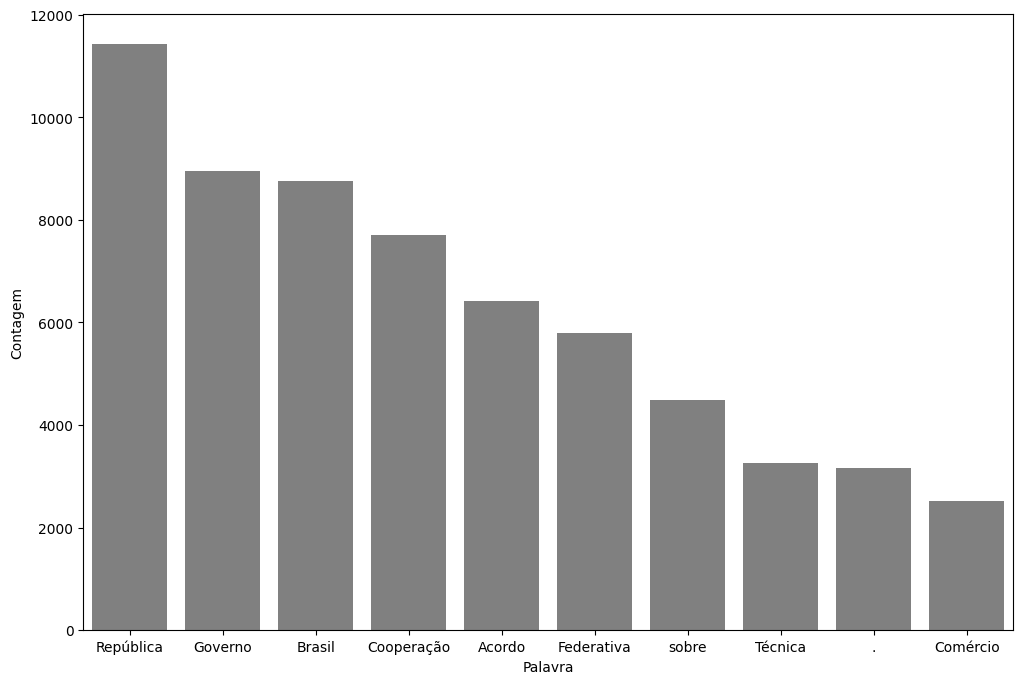

In [50]:
pareto(propostas,"tratamento_1", 10)

In [51]:
from string import punctuation

token_pontuacao = tokenize.WordPunctTokenizer()

pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)

pontuacao_stopwords = pontuacao + palavras_irrelevantes

frase_processada = list()
for opiniao in propostas["tratamento_1"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

propostas["tratamento_2"] = frase_processada



In [52]:
propostas.head()

,Categoria,Texto,id_cats,tratamento_1,tratamento_2
0,Turismo,Turismo: esse é o Destino. Objetivo: Posiciona...,0,Turismo: Destino. Objetivo: Posicionar turismo...,Turismo Destino Objetivo Posicionar turismo ve...
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. Objetivo:...,1,Agricultura Familiar Agroecologia. Objetivo: F...,Agricultura Familiar Agroecologia Objetivo For...
2,Agricultura e Pecuária,Agropecuária Sustentável. Objetivo: Contribuir...,2,Agropecuária Sustentável. Objetivo: Contribuir...,Agropecuária Sustentável Objetivo Contribuir d...
3,Saúde,Atenção Primária à Saúde. Fortalecer a Atenção...,3,Atenção Primária Saúde. Fortalecer Atenção Pri...,Atenção Primária Saúde Fortalecer Atenção Prim...
4,Saúde,Atenção Especializada à Saúde. Ampliar o acess...,3,Atenção Especializada Saúde. Ampliar acesso aç...,Atenção Especializada Saúde Ampliar acesso açõ...


In [53]:
acuracia_tratamento2 = classificar_texto(propostas, "tratamento_2", "id_cats")
print(acuracia_tratamento2)


0.6856920986216268


In [54]:
propostas["tratamento_1"][0]

'Turismo: Destino. Objetivo: Posicionar turismo vetor desenvolvimento sustentável aumentar competitividade destinos produtos turísticos brasileiros, democratizando acesso atividade turística cidadãos brasileiros.'

In [55]:
propostas["tratamento_2"][0]

'Turismo Destino Objetivo Posicionar turismo vetor desenvolvimento sustentável aumentar competitividade destinos produtos turísticos brasileiros democratizando acesso atividade turística cidadãos brasileiros'

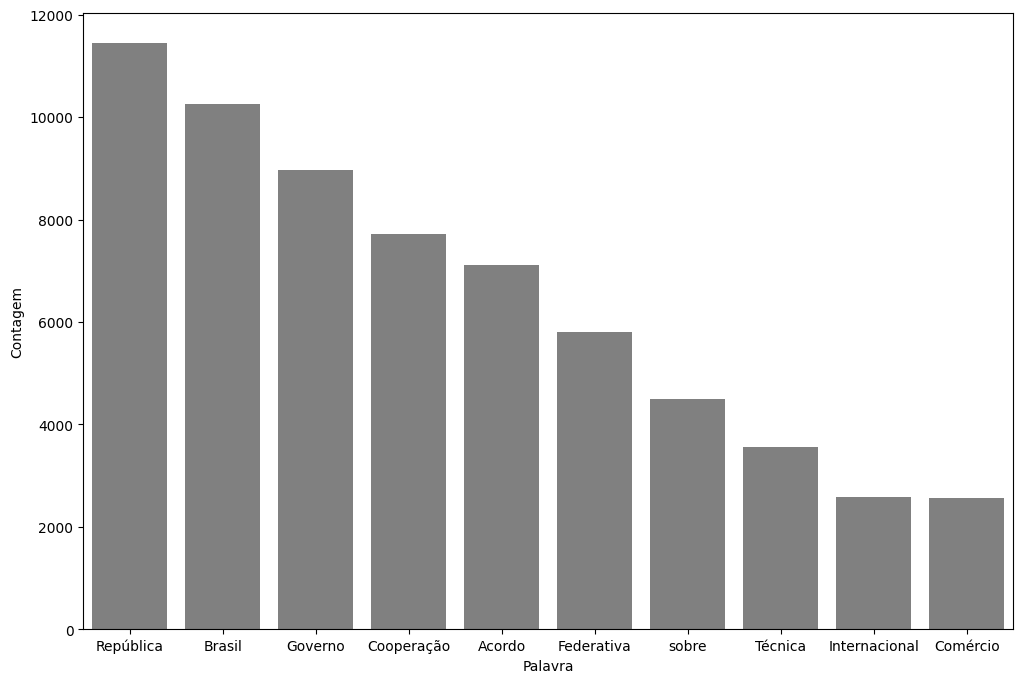

In [56]:
pareto(propostas,"tratamento_2", 10)

In [57]:
import unidecode 

sem_acentos = [unidecode.unidecode(texto) for texto in propostas["tratamento_2"]]


In [58]:
sem_acentos[0]

'Turismo Destino Objetivo Posicionar turismo vetor desenvolvimento sustentavel aumentar competitividade destinos produtos turisticos brasileiros democratizando acesso atividade turistica cidadaos brasileiros'

In [59]:
stopwords_sem_acento = [unidecode.unidecode(texto) for texto in pontuacao_stopwords]

In [60]:
stopwords_sem_acento

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 'a',
 'a',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'as',
 'ate',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'e',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'eramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'esta',
 'estamos',
 'estao',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estavamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estiveramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivessemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'foramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fossemos',
 'fui',
 'ha',
 'haja

In [61]:
propostas["tratamento_3"] = sem_acentos

frase_processada = list()
for opiniao in propostas["tratamento_3"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

propostas["tratamento_3"] = frase_processada



In [62]:
propostas.head()

,Categoria,Texto,id_cats,tratamento_1,tratamento_2,tratamento_3
0,Turismo,Turismo: esse é o Destino. Objetivo: Posiciona...,0,Turismo: Destino. Objetivo: Posicionar turismo...,Turismo Destino Objetivo Posicionar turismo ve...,Turismo Destino Objetivo Posicionar turismo ve...
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. Objetivo:...,1,Agricultura Familiar Agroecologia. Objetivo: F...,Agricultura Familiar Agroecologia Objetivo For...,Agricultura Familiar Agroecologia Objetivo For...
2,Agricultura e Pecuária,Agropecuária Sustentável. Objetivo: Contribuir...,2,Agropecuária Sustentável. Objetivo: Contribuir...,Agropecuária Sustentável Objetivo Contribuir d...,Agropecuaria Sustentavel Objetivo Contribuir d...
3,Saúde,Atenção Primária à Saúde. Fortalecer a Atenção...,3,Atenção Primária Saúde. Fortalecer Atenção Pri...,Atenção Primária Saúde Fortalecer Atenção Prim...,Atencao Primaria Saude Fortalecer Atencao Prim...
4,Saúde,Atenção Especializada à Saúde. Ampliar o acess...,3,Atenção Especializada Saúde. Ampliar acesso aç...,Atenção Especializada Saúde Ampliar acesso açõ...,Atencao Especializada Saude Ampliar acesso aco...


In [63]:
acuracia_tratamento3 = classificar_texto(propostas, "tratamento_3", "id_cats")
print(acuracia_tratamento3)



0.6843331391962726


In [64]:
#deixa todas as letras minusculas
frase_processada = list()
for opiniao in propostas["tratamento_3"]:
    nova_frase = list()
    opiniao = opiniao.lower()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in stopwords_sem_acento:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))

propostas["tratamento_4"] = frase_processada

In [65]:
propostas["tratamento_3"][0]

'Turismo Destino Objetivo Posicionar turismo vetor desenvolvimento sustentavel aumentar competitividade destinos produtos turisticos brasileiros democratizando acesso atividade turistica cidadaos brasileiros'

In [66]:
propostas["tratamento_4"][0]

'turismo destino objetivo posicionar turismo vetor desenvolvimento sustentavel aumentar competitividade destinos produtos turisticos brasileiros democratizando acesso atividade turistica cidadaos brasileiros'

In [67]:
acuracia_tratamento4 = classificar_texto(propostas, "tratamento_4", "id_cats")
print(acuracia_tratamento4)


0.7076295864880606


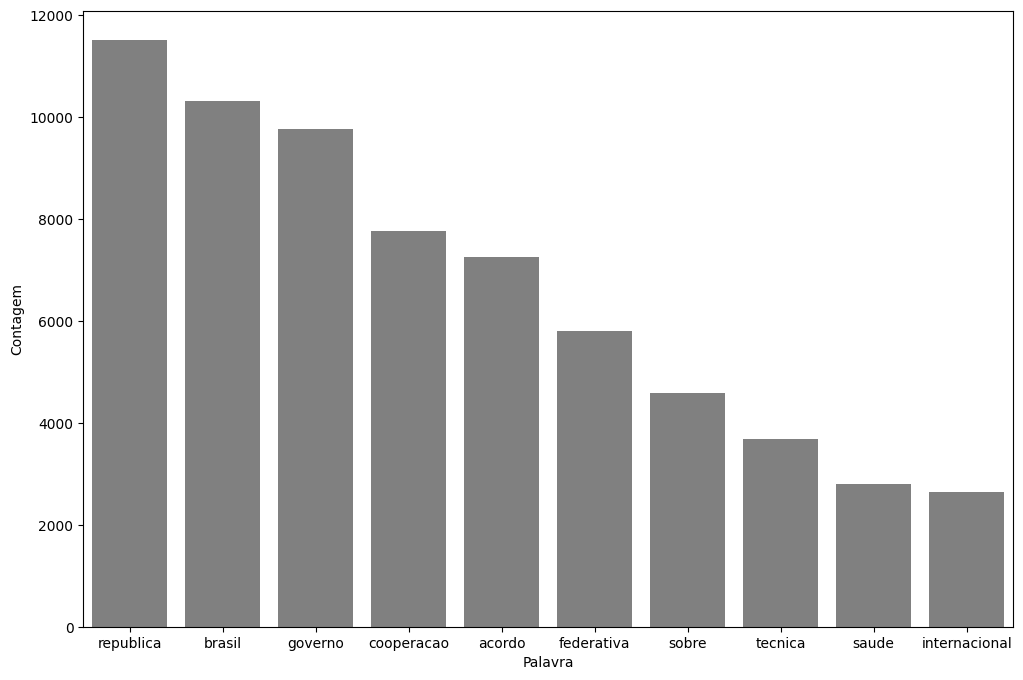

In [68]:
pareto(propostas, "tratamento_4", 10)

# Teste com a Stemização


In [69]:
nltk.download('rslp')
# faz a stemetizacao
stemmer = nltk.RSLPStemmer()

[nltk_data] Downloading package rslp to /home/leandro/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [70]:
frase_processada = list()
for opiniao in propostas["tratamento_4"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in stopwords_sem_acento:
            nova_frase.append(stemmer.stem(palavra))
    frase_processada.append(' '.join(nova_frase))

propostas["tratamento_5"] = frase_processada


In [71]:
acuracia_tratamento5 = classificar_texto(propostas, "tratamento_5", "id_cats")
print(acuracia_tratamento5)

0.7093768200349446


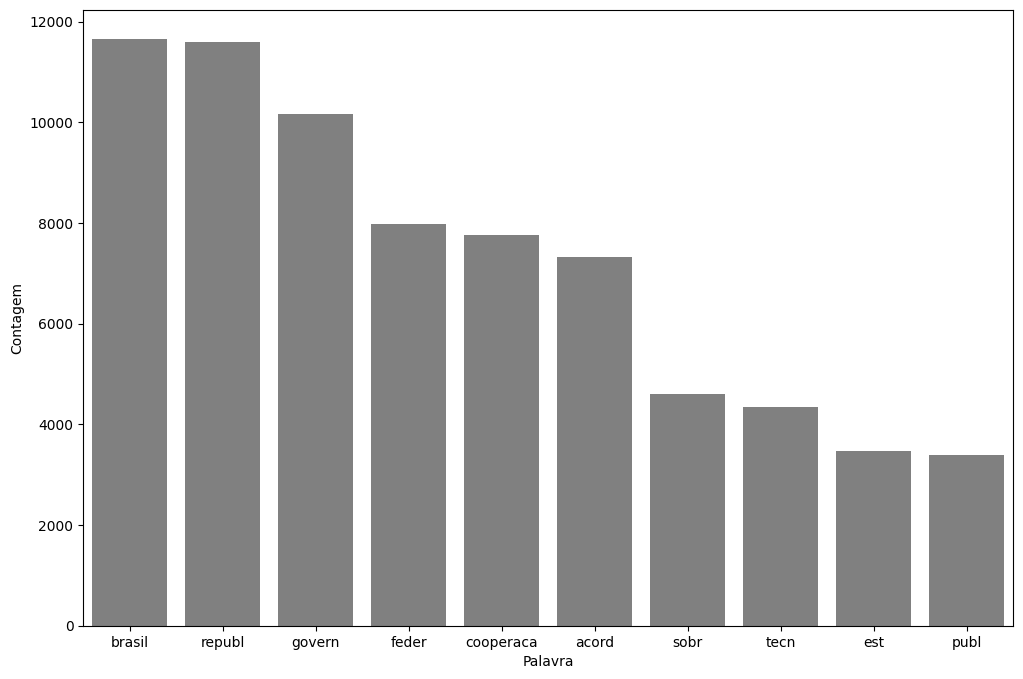

In [72]:
pareto(propostas, "tratamento_5", 10)

# Testando a utilização do TF-IDF no dataframe

In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase=False, max_features=50)

tfidf_tratados = tfidf.fit_transform(propostas["tratamento_5"])
treino, teste, classe_treino, classe_teste = train_test_split(tfidf_tratados,
                                                              propostas["id_cats"],
                                                              random_state = 42)
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf_tratados = regressao_logistica.score(teste, classe_teste)

print(acuracia_tfidf_tratados)



0.7124830130071831


# Testando a utilizacao do TF-IDF juntamente com o ngrams


In [74]:
from nltk import ngrams

#acuracia do tfidf utilizando os ngrams
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
vetor_tfidf = tfidf.fit_transform(propostas["tratamento_5"])
treino, teste, classe_treino, classe_teste = train_test_split(vetor_tfidf,
                                                              propostas["id_cats"],
                                                              random_state = 42)
regressao_logistica.fit(treino, classe_treino)
acuracia_tfidf_ngrams = regressao_logistica.score(teste, classe_teste)
print(acuracia_tfidf_ngrams)


0.7901378373131431


In [75]:
#palavras que o modelo aprendeu da categoria saude (id_cats 3)
pesos = pd.DataFrame(
    regressao_logistica.coef_[3].T,
    index = tfidf.get_feature_names_out()
)

pesos.nlargest(50,0)



,0
saud,9.054355
su,6.218300
enferm,4.568884
medic,4.356720
hospit,4.145443
paci,3.571539
atend,3.358660
doenc,3.275804
pis,3.039454
atenca,2.761615


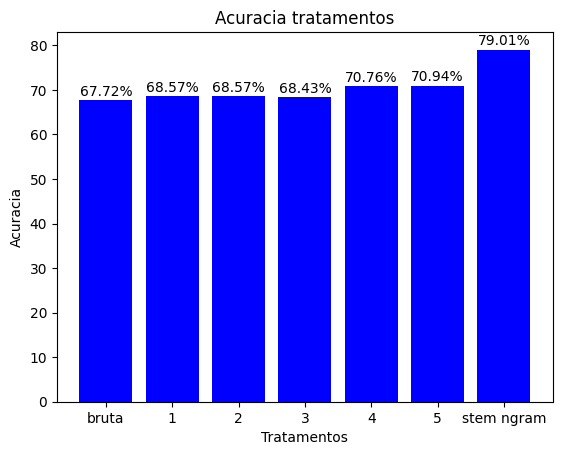

In [76]:
import matplotlib.pyplot as plt

# Dados numéricos
dados = [acuracia_bruta * 100, acuracia_tratamento_1 * 100, acuracia_tratamento2 * 100,
         acuracia_tratamento3 * 100, acuracia_tratamento4 * 100, acuracia_tratamento5 * 100,
         acuracia_tfidf_ngrams * 100]
etiquetas = ['bruta', '1', '2', '3', '4', '5', 'stem ngram']

# Criar o gráfico de barras
plt.bar(etiquetas, dados, color='blue')

# Adicionar título e rótulos dos eixos
plt.title('Acuracia tratamentos')
plt.xlabel('Tratamentos')
plt.ylabel('Acuracia')

# Adicionar os valores acima de cada barra
for i, valor in enumerate(dados):
    plt.text(i, valor + 1, f'{valor:.2f}%', ha='center')

# Exibir o gráfico
plt.show()


# Testando com o SVM utilizando o tratamento 4 ou seja sem a stemizacao


In [77]:
propostas.head()

,Categoria,Texto,id_cats,tratamento_1,tratamento_2,tratamento_3,tratamento_4,tratamento_5
0,Turismo,Turismo: esse é o Destino. Objetivo: Posiciona...,0,Turismo: Destino. Objetivo: Posicionar turismo...,Turismo Destino Objetivo Posicionar turismo ve...,Turismo Destino Objetivo Posicionar turismo ve...,turismo destino objetivo posicionar turismo ve...,tur destin obje posic tur vet desenvolv susten...
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. Objetivo:...,1,Agricultura Familiar Agroecologia. Objetivo: F...,Agricultura Familiar Agroecologia Objetivo For...,Agricultura Familiar Agroecologia Objetivo For...,agricultura familiar agroecologia objetivo for...,agricult famili agroecolog obje fortalec agric...
2,Agricultura e Pecuária,Agropecuária Sustentável. Objetivo: Contribuir...,2,Agropecuária Sustentável. Objetivo: Contribuir...,Agropecuária Sustentável Objetivo Contribuir d...,Agropecuaria Sustentavel Objetivo Contribuir d...,agropecuaria sustentavel objetivo contribuir d...,agropecu sustenta obje contribu desenvolv set ...
3,Saúde,Atenção Primária à Saúde. Fortalecer a Atenção...,3,Atenção Primária Saúde. Fortalecer Atenção Pri...,Atenção Primária Saúde Fortalecer Atenção Prim...,Atencao Primaria Saude Fortalecer Atencao Prim...,atencao primaria saude fortalecer atencao prim...,atenca prim saud fortalec atenca prim saud amp...
4,Saúde,Atenção Especializada à Saúde. Ampliar o acess...,3,Atenção Especializada Saúde. Ampliar acesso aç...,Atenção Especializada Saúde Ampliar acesso açõ...,Atencao Especializada Saude Ampliar acesso aco...,atencao especializada saude ampliar acesso aco...,atenca especi saud ampli acess aco serv atenca...


In [78]:
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

nlp = spacy.load("pt_core_news_sm") 

In [79]:
#  Representações vetoriais do texto
propostas['Vector'] = propostas['tratamento_4'].apply(lambda text: nlp(text).vector)
propostas.head()

,Categoria,Texto,id_cats,tratamento_1,tratamento_2,tratamento_3,tratamento_4,tratamento_5,Vector
0,Turismo,Turismo: esse é o Destino. Objetivo: Posiciona...,0,Turismo: Destino. Objetivo: Posicionar turismo...,Turismo Destino Objetivo Posicionar turismo ve...,Turismo Destino Objetivo Posicionar turismo ve...,turismo destino objetivo posicionar turismo ve...,tur destin obje posic tur vet desenvolv susten...,"[0.5342788, -0.02215004, -1.2641032, 1.0001749..."
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. Objetivo:...,1,Agricultura Familiar Agroecologia. Objetivo: F...,Agricultura Familiar Agroecologia Objetivo For...,Agricultura Familiar Agroecologia Objetivo For...,agricultura familiar agroecologia objetivo for...,agricult famili agroecolog obje fortalec agric...,"[-1.2358813, 1.6805391, -1.060905, 1.7490906, ..."
2,Agricultura e Pecuária,Agropecuária Sustentável. Objetivo: Contribuir...,2,Agropecuária Sustentável. Objetivo: Contribuir...,Agropecuária Sustentável Objetivo Contribuir d...,Agropecuaria Sustentavel Objetivo Contribuir d...,agropecuaria sustentavel objetivo contribuir d...,agropecu sustenta obje contribu desenvolv set ...,"[-0.82804227, 0.28899813, -1.0518178, 0.757611..."
3,Saúde,Atenção Primária à Saúde. Fortalecer a Atenção...,3,Atenção Primária Saúde. Fortalecer Atenção Pri...,Atenção Primária Saúde Fortalecer Atenção Prim...,Atencao Primaria Saude Fortalecer Atencao Prim...,atencao primaria saude fortalecer atencao prim...,atenca prim saud fortalec atenca prim saud amp...,"[-1.656974, 0.9785775, -0.17303438, 2.8001835,..."
4,Saúde,Atenção Especializada à Saúde. Ampliar o acess...,3,Atenção Especializada Saúde. Ampliar acesso aç...,Atenção Especializada Saúde Ampliar acesso açõ...,Atencao Especializada Saude Ampliar acesso aco...,atencao especializada saude ampliar acesso aco...,atenca especi saud ampli acess aco serv atenca...,"[0.14726149, 0.8421647, 0.023294887, 1.8071848..."


In [80]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, model_selection
import numpy as np


In [81]:
# Separação dos dados para treinamento e teste
treino, teste, classe_treino, classe_teste = model_selection.train_test_split(
    propostas.Vector.values,
    propostas.Categoria,
    test_size=0.2
)

# Transformação: conversão do tipo dos dados de entrada (X) para interpretação
treino_2d = np.stack(treino)
teste_2d = np.stack(teste)

# Transformação: escalonamento dos dados numéricos (normalizados entre 0 e 1)
# Para tratamento de casos outliers
scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(treino_2d)
scaled_test_embed = scaler.transform(teste_2d)

In [82]:
import json

# Treinamento
clf = svm.SVC() # Instanciando modelo
clf.fit(scaled_train_embed, classe_treino)  # Realização do treinamento passando os dados

classe_pred = clf.predict(scaled_test_embed) # Predição com os dados de teste

# Impressão do relatório com as métricas do modelo (para cada cat.)
print(classification_report(classe_teste, classe_pred))  

predictions_SVM = clf.predict(scaled_test_embed)
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, classe_teste)*100)  # Impressão da precisão geral

/home/leandro/Documentos/07_ProcessamentoLinguagemNatural/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leandro/Documentos/07_ProcessamentoLinguagemNatural/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leandro/Documentos/07_ProcessamentoLinguagemNatural/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

                                                                precision    recall  f1-score   support

                                      Advocacia-Geral da União       0.00      0.00      0.00         2
                                        Agricultura e Pecuária       0.00      0.00      0.00        17
                                                 Banco Central       0.00      0.00      0.00         7
                                                    Casa Civil       0.00      0.00      0.00         6
                                                       Cidades       0.00      0.00      0.00        67
                                Ciência, Tecnologia e Inovação       0.00      0.00      0.00        23
                                            Comunicação Social       0.00      0.00      0.00        10
                                                  Comunicações       0.00      0.00      0.00        11
                                  Controladoria-Geral da União 

# Teste da regressao logistica com a lematizacao usando o spacy

In [83]:
propostas.head()

,Categoria,Texto,id_cats,tratamento_1,tratamento_2,tratamento_3,tratamento_4,tratamento_5,Vector
0,Turismo,Turismo: esse é o Destino. Objetivo: Posiciona...,0,Turismo: Destino. Objetivo: Posicionar turismo...,Turismo Destino Objetivo Posicionar turismo ve...,Turismo Destino Objetivo Posicionar turismo ve...,turismo destino objetivo posicionar turismo ve...,tur destin obje posic tur vet desenvolv susten...,"[0.5342788, -0.02215004, -1.2641032, 1.0001749..."
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. Objetivo:...,1,Agricultura Familiar Agroecologia. Objetivo: F...,Agricultura Familiar Agroecologia Objetivo For...,Agricultura Familiar Agroecologia Objetivo For...,agricultura familiar agroecologia objetivo for...,agricult famili agroecolog obje fortalec agric...,"[-1.2358813, 1.6805391, -1.060905, 1.7490906, ..."
2,Agricultura e Pecuária,Agropecuária Sustentável. Objetivo: Contribuir...,2,Agropecuária Sustentável. Objetivo: Contribuir...,Agropecuária Sustentável Objetivo Contribuir d...,Agropecuaria Sustentavel Objetivo Contribuir d...,agropecuaria sustentavel objetivo contribuir d...,agropecu sustenta obje contribu desenvolv set ...,"[-0.82804227, 0.28899813, -1.0518178, 0.757611..."
3,Saúde,Atenção Primária à Saúde. Fortalecer a Atenção...,3,Atenção Primária Saúde. Fortalecer Atenção Pri...,Atenção Primária Saúde Fortalecer Atenção Prim...,Atencao Primaria Saude Fortalecer Atencao Prim...,atencao primaria saude fortalecer atencao prim...,atenca prim saud fortalec atenca prim saud amp...,"[-1.656974, 0.9785775, -0.17303438, 2.8001835,..."
4,Saúde,Atenção Especializada à Saúde. Ampliar o acess...,3,Atenção Especializada Saúde. Ampliar acesso aç...,Atenção Especializada Saúde Ampliar acesso açõ...,Atencao Especializada Saude Ampliar acesso aco...,atencao especializada saude ampliar acesso aco...,atenca especi saud ampli acess aco serv atenca...,"[0.14726149, 0.8421647, 0.023294887, 1.8071848..."


In [84]:
frase_processada = list()
for opiniao in propostas["tratamento_4"]:
    nova_frase = list()
    doc = nlp(opiniao)
    for token in doc:
        nova_frase.append(token.lemma_)
    frase_processada.append(' '.join(nova_frase))

propostas["tratamento_6"] = frase_processada


In [85]:
propostas.head()

,Categoria,Texto,id_cats,tratamento_1,tratamento_2,tratamento_3,tratamento_4,tratamento_5,Vector,tratamento_6
0,Turismo,Turismo: esse é o Destino. Objetivo: Posiciona...,0,Turismo: Destino. Objetivo: Posicionar turismo...,Turismo Destino Objetivo Posicionar turismo ve...,Turismo Destino Objetivo Posicionar turismo ve...,turismo destino objetivo posicionar turismo ve...,tur destin obje posic tur vet desenvolv susten...,"[0.5342788, -0.02215004, -1.2641032, 1.0001749...",Turismo destino objetivo posicionar turismo ve...
1,Desenvolvimento Agrário e Agricultura Familiar,Agricultura Familiar e Agroecologia. Objetivo:...,1,Agricultura Familiar Agroecologia. Objetivo: F...,Agricultura Familiar Agroecologia Objetivo For...,Agricultura Familiar Agroecologia Objetivo For...,agricultura familiar agroecologia objetivo for...,agricult famili agroecolog obje fortalec agric...,"[-1.2358813, 1.6805391, -1.060905, 1.7490906, ...",agricultura familiar agroecologia objetivo for...
2,Agricultura e Pecuária,Agropecuária Sustentável. Objetivo: Contribuir...,2,Agropecuária Sustentável. Objetivo: Contribuir...,Agropecuária Sustentável Objetivo Contribuir d...,Agropecuaria Sustentavel Objetivo Contribuir d...,agropecuaria sustentavel objetivo contribuir d...,agropecu sustenta obje contribu desenvolv set ...,"[-0.82804227, 0.28899813, -1.0518178, 0.757611...",agropecuar sustentavel objetivo contribuir des...
3,Saúde,Atenção Primária à Saúde. Fortalecer a Atenção...,3,Atenção Primária Saúde. Fortalecer Atenção Pri...,Atenção Primária Saúde Fortalecer Atenção Prim...,Atencao Primaria Saude Fortalecer Atencao Prim...,atencao primaria saude fortalecer atencao prim...,atenca prim saud fortalec atenca prim saud amp...,"[-1.656974, 0.9785775, -0.17303438, 2.8001835,...",atencao primario saude fortalecer atencao prim...
4,Saúde,Atenção Especializada à Saúde. Ampliar o acess...,3,Atenção Especializada Saúde. Ampliar acesso aç...,Atenção Especializada Saúde Ampliar acesso açõ...,Atencao Especializada Saude Ampliar acesso aco...,atencao especializada saude ampliar acesso aco...,atenca especi saud ampli acess aco serv atenca...,"[0.14726149, 0.8421647, 0.023294887, 1.8071848...",atencao especializar saude ampliar acesso acoe...


In [86]:
from nltk import ngrams

#acuracia do tfidf utilizando os ngrams
tfidf = TfidfVectorizer(lowercase=False, ngram_range = (1,2))
vetor_tfidf = tfidf.fit_transform(propostas["tratamento_6"])
treino, teste, classe_treino, classe_teste = train_test_split(vetor_tfidf,
                                                              propostas["id_cats"],
                                                              random_state = 42)
regressao_logistica.fit(treino, classe_treino)
acuracia_lemma = regressao_logistica.score(teste, classe_teste)
print(acuracia_lemma)


0.7802368472141332


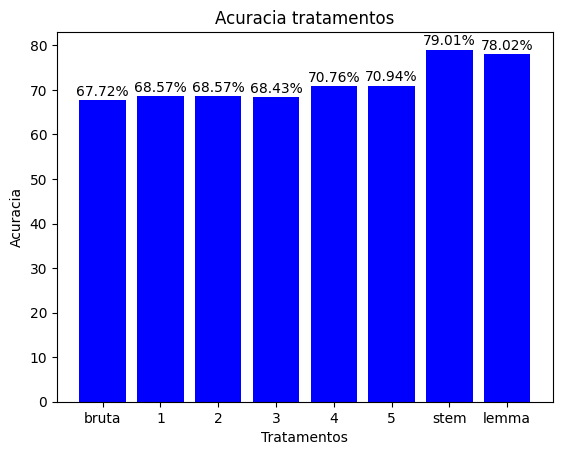

In [87]:
import matplotlib.pyplot as plt

# Dados numéricos
dados = [acuracia_bruta * 100, acuracia_tratamento_1 * 100, acuracia_tratamento2 * 100,
         acuracia_tratamento3 * 100, acuracia_tratamento4 * 100, acuracia_tratamento5 * 100,
         acuracia_tfidf_ngrams * 100,acuracia_lemma * 100]
etiquetas = ['bruta', '1', '2', '3', '4', '5', 'stem','lemma']
 
# Criar o gráfico de barras
plt.bar(etiquetas, dados, color='blue')

# Adicionar título e rótulos dos eixos
plt.title('Acuracia tratamentos')
plt.xlabel('Tratamentos')
plt.ylabel('Acuracia')

# Adicionar os valores acima de cada barra
for i, valor in enumerate(dados):
    plt.text(i, valor + 1, f'{valor:.2f}%', ha='center')

# Exibir o gráfico
plt.show()

# Aplicando o TF-IDF com Ngrams nos dados sem stemizacao e lematizacao no SVC


In [88]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Dividir dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(propostas['tratamento_4'],propostas["Categoria"], test_size=0.2, random_state=42)

# Criar vetorizador TF-IDF com n-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Aqui usamos bigrams
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Treinar SVM
svm_model = SVC(kernel='linear')  # Pode usar outros kernels também
svm_model.fit(X_train_tfidf, y_train)

# Prever e avaliar
y_pred = svm_model.predict(X_test_tfidf)
report = classification_report(y_test, y_pred)

print(report)



                                                                precision    recall  f1-score   support

                                      Advocacia-Geral da União       0.00      0.00      0.00         4
                                        Agricultura e Pecuária       0.20      0.05      0.07        22
                                                 Banco Central       1.00      0.20      0.33         5
                                                    Casa Civil       0.00      0.00      0.00         7
                                                       Cidades       0.46      0.42      0.44        55
                                Ciência, Tecnologia e Inovação       0.57      0.23      0.33        35
                                            Comunicação Social       0.00      0.00      0.00        10
                                                  Comunicações       1.00      0.22      0.36         9
                                  Controladoria-Geral da União 

/home/leandro/Documentos/07_ProcessamentoLinguagemNatural/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leandro/Documentos/07_ProcessamentoLinguagemNatural/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leandro/Documentos/07_ProcessamentoLinguagemNatural/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

# Aplicando o TF-IDF com Ngrams nos dados com lematizacao no SVC

In [89]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Dividir dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(propostas['tratamento_6'],propostas["Categoria"], test_size=0.2, random_state=42)

# Criar vetorizador TF-IDF com n-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Aqui usamos bigrams
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Treinar SVM
svm_model = SVC(kernel='linear')  # Pode usar outros kernels também
svm_model.fit(X_train_tfidf, y_train)

# Prever e avaliar
y_pred = svm_model.predict(X_test_tfidf)
report = classification_report(y_test, y_pred,output_dict=True)

print(report)

# Salvando relatório de treinamento em um arquivo JSON
json_obj = json.dumps(report, indent=4)
save_file = open('../model_v3/ttraining_results.json', 'w').write(json_obj)





{'Advocacia-Geral da União': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, 'Agricultura e Pecuária': {'precision': 0.2, 'recall': 0.045454545454545456, 'f1-score': 0.07407407407407407, 'support': 22.0}, 'Banco Central': {'precision': 1.0, 'recall': 0.2, 'f1-score': 0.33333333333333337, 'support': 5.0}, 'Casa Civil': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}, 'Cidades': {'precision': 0.45098039215686275, 'recall': 0.41818181818181815, 'f1-score': 0.43396226415094336, 'support': 55.0}, 'Ciência, Tecnologia e Inovação': {'precision': 0.6, 'recall': 0.2571428571428571, 'f1-score': 0.36, 'support': 35.0}, 'Comunicação Social': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 10.0}, 'Comunicações': {'precision': 1.0, 'recall': 0.3333333333333333, 'f1-score': 0.5, 'support': 9.0}, 'Controladoria-Geral da União': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5.0}, 'Cultura': {'precision': 0.6756756756756757, 'recall': 

/home/leandro/Documentos/07_ProcessamentoLinguagemNatural/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leandro/Documentos/07_ProcessamentoLinguagemNatural/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/leandro/Documentos/07_ProcessamentoLinguagemNatural/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

## A ideia de utilziar dados publicos dos ministerios no gov foi descartada pois nao iria reflitir no vocabulario publico das pessoas que utilizam o brasil participativo
